# Analyses simulation study guidelines KIFMS
This script provides analyses of the simulation studies on three levels:
1. On the overall level, descriptives are provided.
2. On label-level simulation metrics are given per:
  * 'clinician-inclusion'
  * 'expert_inclusion'
  * 'full-inclusion'
3. For each dataset separately aggregated simulation metrics are provided for wss95 and rrf10.

## Table of contents
1. Loading libraries and defining file paths
2. Read and prepare data
    1. Metadata
    2. Article descriptives
    3. Data descriptives
    4. Data on state metrics
3. Dataset characteristics:
   1. Overall
   2. On label-level
       - Noisy/Clinician-inclusion
       - Expert-inclusion
       - Full-inclusion
   3. Per dataset for each label-level
       - Noisy/Clinician-inclusion
       - Expert-inclusion
       - Full-inclusion
4. Simulation performance:
   1. Overall
   2. On label-level
       - Noisy/Clinician-inclusion
       - Expert-inclusion
       - Full-inclusion
   3. Per dataset for each label-level
       - Noisy/Clinician-inclusion
       - Expert-inclusion
       - Full-inclusion


## 1. Loading libraries and defining file paths
Libraries and packages to be used in the code below:

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns

Define the paths to the files to be loaded. 



In [2]:
FP_DATA_DESCRIPTIVES = "../output/tables/data_descriptives.csv"
FP_STATE_METRICS = "../output/tables/data_metrics.csv"
FP_METADATA_DATA_DESCRIPTIVES = "../data/metadata_data_descriptives.xlsx"
FP_ARTICLE_DESCRIPTIVES_OVERALL = "../data/article_descriptives_overall.xlsx"

### Mapping

In [3]:
MAPPING_STAGES = {
    "noisy_inclusion": "Clinician",
    "expert_inclusion": "Research methodologist",
    "fulltext_inclusion": "Final full-text"
}

MAPPING_TITLE_ID = {
    "Distal_radius_fractures_approach": "1",
    "Distal_radius_fractures_closed_reduction" : "2",
    "Hallux_valgus_prognostic": "3",
    "Head_and_neck_cancer_bone":"4",
    "Head_and_neck_cancer_imaging":"5",
    "Obstetric_emergency_training": "6",
    "Post_intensive_care_treatment":"7",
    "Pregnancy_medication": "8",
    "Shoulder_replacement_diagnostic": "9",
    "Shoulder_replacement_surgery":"10",
    "Shoulderdystocia_positioning":"11",
    "Shoulderdystocia_recurrence":"12",
    "Total_knee_replacement":"13",
    "Vascular_access":"14"  
}

SCREENING_ORDER_RAW = ["noisy_inclusion", "expert_inclusion", "fulltext_inclusion"]
SCREENING_ORDER = ["Clinician", "Research methodologist", "Final full-text"]


## 2. Read and prepare data
There are three datasets loaded in the code below:
- `metadata_data_descriptives` contains metadata on the datasets that were used for simulations.
- `article_descriptives_overall` gives some extra information on the datasets, this will be merged to the data_descriptives.
- `data_descriptives` gives a general description of the dataset (how many inclusions, missing titles, etc.)
- `data_metrics` provides the metrics of the simulation study accomponying each dataset.

### 2A. Metadata
The meta_data will be used to prepare the other two datasets for analysis. 

In [4]:
df_metadata = pd.read_excel(FP_METADATA_DATA_DESCRIPTIVES)
df_metadata.head()

,dataset_name,stage,title
0,data/Distal_radius_fractures_approach_expert_i...,expert_inclusion,Distal_radius_fractures_approach
1,data/Distal_radius_fractures_approach_fulltext...,fulltext_inclusion,Distal_radius_fractures_approach
2,data/Distal_radius_fractures_approach_noisy_in...,noisy_inclusion,Distal_radius_fractures_approach
3,data/Distal_radius_fractures_closed_reduction_...,expert_inclusion,Distal_radius_fractures_closed_reduction
4,data/Distal_radius_fractures_closed_reduction_...,fulltext_inclusion,Distal_radius_fractures_closed_reduction


In [5]:
df_metadata["raw_stage"] = df_metadata["stage"]
df_metadata["stage"]= df_metadata["stage"].replace(MAPPING_STAGES)
df_metadata["title_id"] = df_metadata["title"].replace(MAPPING_TITLE_ID)
df_metadata.head()

,dataset_name,stage,title,raw_stage,title_id
0,data/Distal_radius_fractures_approach_expert_i...,Research methodologist,Distal_radius_fractures_approach,expert_inclusion,1
1,data/Distal_radius_fractures_approach_fulltext...,Final full-text,Distal_radius_fractures_approach,fulltext_inclusion,1
2,data/Distal_radius_fractures_approach_noisy_in...,Clinician,Distal_radius_fractures_approach,noisy_inclusion,1
3,data/Distal_radius_fractures_closed_reduction_...,Research methodologist,Distal_radius_fractures_closed_reduction,expert_inclusion,2
4,data/Distal_radius_fractures_closed_reduction_...,Final full-text,Distal_radius_fractures_closed_reduction,fulltext_inclusion,2


### 2B. Article descripives

This data will be attached to the data descriptives.

In [6]:
df_article_descriptives = pd.read_excel(FP_ARTICLE_DESCRIPTIVES_OVERALL)
df_article_descriptives.head()

,dataset,medical_specialty,title,type,screeningtime,kappa
0,1,General Surgery,Distal_radius_fractures_approach,Intervention,225,0.31
1,2,General Surgery,Distal_radius_fractures_closed_reduction,Intervention,294,0.55
2,3,Orthopedic Surgery,Hallux_valgus_prognostic,Prognostic,327,0.64
3,4,ENT Surgery,Head_and_neck_cancer_bone,Diagnostic,253,0.87
4,5,ENT Surgery,Head_and_neck_cancer_imaging,Diagnostic,72,0.61


### 2C. Data descriptives
First the data is loaded into the environment.
Thereafter, five things happen:
1. The metadata is attached to the data
2. The article descriptives overall are attached to the data.
3. Percentages are added after the 'n_included' until 'n_missing_abstract_included' columns 
4. A final column called recall_random95 is created, indicating how many records one needs to read when screening randomly, to find 95% of the relevant records.
5. Pivot the table so that we are left with one row per dataset. 

#### Loading data

In [7]:
df_data_descriptives = pd.read_csv(FP_DATA_DESCRIPTIVES)
print(len(df_data_descriptives))
df_data_descriptives.head()


42


,dataset_name,n_papers,n_included,n_excluded,n_unlabeled,n_missing_title,n_missing_title_included,n_missing_abstract,n_missing_abstract_included,title_length,abstract_length,n_keywords
0,data/Distal_radius_fractures_approach_expert_i...,195,6,189,0,0,0,13,0,113.979487,1277.405128,NaN
1,data/Distal_radius_fractures_approach_fulltext...,195,5,190,0,0,0,13,0,113.979487,1277.405128,NaN
2,data/Distal_radius_fractures_approach_noisy_in...,195,11,184,0,0,0,13,1,113.979487,1277.405128,NaN
3,data/Distal_radius_fractures_closed_reduction_...,277,4,273,0,0,0,21,2,114.306859,1309.422383,NaN
4,data/Distal_radius_fractures_closed_reduction_...,277,4,273,0,0,0,21,2,114.306859,1309.422383,NaN


#### Attaching metadata and article descriptives overall

In [8]:
# Below the columns of df_metadata and df_article_descriptives are added to df_state_data_descriptives based on the dataset_name column
df_data_descriptives_with_meta = df_metadata.merge(df_data_descriptives, on = "dataset_name", how = "left")

df_data_descriptives_full = df_article_descriptives.merge(df_data_descriptives_with_meta, on = "title", how = "left")
print(len(df_data_descriptives_full)) #Checking whether the number of rows is still the same.

# Move columns towards the end:
cols_at_end = ['screeningtime', 'kappa']
df_data_descriptives_full = df_data_descriptives_full[[c for c in df_data_descriptives_full if c not in cols_at_end] 
        + [c for c in cols_at_end if c in df_data_descriptives_full.head()]]

df_data_descriptives_full.head()

42


,dataset,medical_specialty,title,type,dataset_name,stage,raw_stage,title_id,n_papers,n_included,...,n_unlabeled,n_missing_title,n_missing_title_included,n_missing_abstract,n_missing_abstract_included,title_length,abstract_length,n_keywords,screeningtime,kappa
0,1,General Surgery,Distal_radius_fractures_approach,Intervention,data/Distal_radius_fractures_approach_expert_i...,Research methodologist,expert_inclusion,1,195,6,...,0,0,0,13,0,113.979487,1277.405128,NaN,225,0.31
1,1,General Surgery,Distal_radius_fractures_approach,Intervention,data/Distal_radius_fractures_approach_fulltext...,Final full-text,fulltext_inclusion,1,195,5,...,0,0,0,13,0,113.979487,1277.405128,NaN,225,0.31
2,1,General Surgery,Distal_radius_fractures_approach,Intervention,data/Distal_radius_fractures_approach_noisy_in...,Clinician,noisy_inclusion,1,195,11,...,0,0,0,13,1,113.979487,1277.405128,NaN,225,0.31
3,2,General Surgery,Distal_radius_fractures_closed_reduction,Intervention,data/Distal_radius_fractures_closed_reduction_...,Research methodologist,expert_inclusion,2,277,4,...,0,0,0,21,2,114.306859,1309.422383,NaN,294,0.55
4,2,General Surgery,Distal_radius_fractures_closed_reduction,Intervention,data/Distal_radius_fractures_closed_reduction_...,Final full-text,fulltext_inclusion,2,277,4,...,0,0,0,21,2,114.306859,1309.422383,NaN,294,0.55


#### Add percentages to columns

In [9]:
for column in ['n_included', 
               'n_excluded', 
               'n_unlabeled',
               'n_missing_title',
               'n_missing_title_included',
               'n_missing_abstract', 
               'n_missing_abstract_included']:
    # Create the new column name
    perc_column = column + '_%'
    # Specify after which column the results should be visible
    idx = df_data_descriptives_full.columns.get_loc(column)
    # What values should go in there?
    perc_value = round((df_data_descriptives_full[column]/df_data_descriptives_full['n_papers']*100), 2)
    # Insert the columns
    df_data_descriptives_full.insert(loc=idx+1, column=perc_column, value=perc_value)

#### Calculate when 95% of all relevant records would be found when screening randomly

In [10]:
# How many records would one have to screen on average to find a relevant paper?
random_papers = df_data_descriptives_full['n_papers']/df_data_descriptives_full['n_included']
# How many records is 95% of all relevant records?
inclusions95 = np.floor(0.95*df_data_descriptives_full['n_included'])
# How many records are then screened to find 95% of all relevant records?
recall_random95 = np.floor(inclusions95 * random_papers)
df_data_descriptives_full['recall_random95'] = recall_random95
print(len(df_data_descriptives_full))

df_data_descriptives_full.head()

42


,dataset,medical_specialty,title,type,dataset_name,stage,raw_stage,title_id,n_papers,n_included,...,n_missing_abstract,n_missing_abstract_%,n_missing_abstract_included,n_missing_abstract_included_%,title_length,abstract_length,n_keywords,screeningtime,kappa,recall_random95
0,1,General Surgery,Distal_radius_fractures_approach,Intervention,data/Distal_radius_fractures_approach_expert_i...,Research methodologist,expert_inclusion,1,195,6,...,13,6.67,0,0.00,113.979487,1277.405128,NaN,225,0.31,162.0
1,1,General Surgery,Distal_radius_fractures_approach,Intervention,data/Distal_radius_fractures_approach_fulltext...,Final full-text,fulltext_inclusion,1,195,5,...,13,6.67,0,0.00,113.979487,1277.405128,NaN,225,0.31,156.0
2,1,General Surgery,Distal_radius_fractures_approach,Intervention,data/Distal_radius_fractures_approach_noisy_in...,Clinician,noisy_inclusion,1,195,11,...,13,6.67,1,0.51,113.979487,1277.405128,NaN,225,0.31,177.0
3,2,General Surgery,Distal_radius_fractures_closed_reduction,Intervention,data/Distal_radius_fractures_closed_reduction_...,Research methodologist,expert_inclusion,2,277,4,...,21,7.58,2,0.72,114.306859,1309.422383,NaN,294,0.55,207.0
4,2,General Surgery,Distal_radius_fractures_closed_reduction,Intervention,data/Distal_radius_fractures_closed_reduction_...,Final full-text,fulltext_inclusion,2,277,4,...,21,7.58,2,0.72,114.306859,1309.422383,NaN,294,0.55,207.0


#### Pivot the table
Meaning that we will flatten the table into a wider format, so a single row represents all levels of a single dataset. 

In [11]:
df_data_descriptives_full_pivot = df_data_descriptives_full.pivot(index=['dataset', 'title', 'title_id'], 
              columns='stage', 
              values=['n_papers',
                     'n_included',
                     'n_included_%',
                     'n_excluded',
                     'n_excluded_%',
                     'n_unlabeled',
                     'n_unlabeled_%',
                     'n_missing_title',
                     'n_missing_title_%',
                     'n_missing_title_included',
                     'n_missing_title_included_%',
                     'n_missing_abstract',
                     'n_missing_abstract_%',
                     'n_missing_abstract_included',
                     'n_missing_abstract_included_%',
                     'title_length',
                     'abstract_length',
                     'recall_random95',
                     'screeningtime', 
                     'kappa']
                    )
               
df_data_descriptives_full_pivot.columns = df_data_descriptives_full_pivot.columns.map('_'.join)
print(len(df_data_descriptives_full_pivot))
df_data_descriptives_full_pivot.head()

14


,,,n_papers_Clinician,n_papers_Final full-text,n_papers_Research methodologist,n_included_Clinician,n_included_Final full-text,n_included_Research methodologist,n_included_%_Clinician,n_included_%_Final full-text,n_included_%_Research methodologist,n_excluded_Clinician,...,abstract_length_Research methodologist,recall_random95_Clinician,recall_random95_Final full-text,recall_random95_Research methodologist,screeningtime_Clinician,screeningtime_Final full-text,screeningtime_Research methodologist,kappa_Clinician,kappa_Final full-text,kappa_Research methodologist
dataset,title,title_id,,,,,,,,,,,,,,,,,,,,,
1,Distal_radius_fractures_approach,1,195.0,195.0,195.0,11.0,5.0,6.0,5.64,2.56,3.08,184.0,...,1277.405128,177.0,156.0,162.0,225.0,225.0,225.0,0.31,0.31,0.31
2,Distal_radius_fractures_closed_reduction,2,277.0,277.0,277.0,8.0,4.0,4.0,2.89,1.44,1.44,269.0,...,1309.422383,242.0,207.0,207.0,294.0,294.0,294.0,0.55,0.55,0.55
3,Hallux_valgus_prognostic,3,640.0,640.0,640.0,20.0,12.0,14.0,3.12,1.88,2.19,620.0,...,1233.048438,608.0,586.0,594.0,327.0,327.0,327.0,0.64,0.64,0.64
4,Head_and_neck_cancer_bone,4,311.0,311.0,311.0,34.0,11.0,20.0,10.93,3.54,6.43,277.0,...,1226.279743,292.0,282.0,295.0,253.0,253.0,253.0,0.87,0.87,0.87
5,Head_and_neck_cancer_imaging,5,56.0,56.0,56.0,18.0,8.0,9.0,32.14,14.29,16.07,38.0,...,1512.303571,52.0,49.0,49.0,72.0,72.0,72.0,0.61,0.61,0.61


### 2D. Data on state metrics
First the data is loaded from the csv file.
Then some transformations are applied:
1. The dataset_names are altered to be in line with the other tables
2. The metadata is attached to the dataframe


In [12]:
df_state_metrics = pd.read_csv(FP_STATE_METRICS)
df_state_metrics.rename({"dataset_name":"state_name"}, axis = 1, inplace = True) # Will be removed later on

# 1. Below the columns data_set name is transformed to look like dataset_name column of df_metadata
df_state_metrics["dataset_name"] = df_state_metrics["state_name"].apply(lambda fp: f"data/{Path(fp).parts[2]}.csv")


# 2. Then the columns of df_metadata are added to df_state_metrics based on the dataset_name column.
df_state_metrics = df_metadata.merge(df_state_metrics, on = "dataset_name", how = "right")


print(len(df_state_metrics))
df_state_metrics.head()


638


,dataset_name,stage,title,raw_stage,title_id,state_name,model,query_strategy,balance_strategy,feature_extraction,n_instances,wss95,wss100,rrf5,rrf10,loss,n_states
0,data/Distal_radius_fractures_approach_expert_i...,Research methodologist,Distal_radius_fractures_approach,expert_inclusion,1,output/simulation/Distal_radius_fractures_appr...,nb,max,double,tfidf,1,53.804348,53.804348,40.0,40.0,0.190769,1
1,data/Distal_radius_fractures_approach_expert_i...,Research methodologist,Distal_radius_fractures_approach,expert_inclusion,1,output/simulation/Distal_radius_fractures_appr...,nb,max,double,tfidf,1,64.130435,64.130435,0.0,20.0,0.210256,1
2,data/Distal_radius_fractures_approach_expert_i...,Research methodologist,Distal_radius_fractures_approach,expert_inclusion,1,output/simulation/Distal_radius_fractures_appr...,nb,max,double,tfidf,1,51.630435,51.630435,20.0,40.0,0.197949,1
3,data/Distal_radius_fractures_approach_expert_i...,Research methodologist,Distal_radius_fractures_approach,expert_inclusion,1,output/simulation/Distal_radius_fractures_appr...,nb,max,double,tfidf,1,61.956522,61.956522,0.0,0.0,0.240000,1
4,data/Distal_radius_fractures_approach_expert_i...,Research methodologist,Distal_radius_fractures_approach,expert_inclusion,1,output/simulation/Distal_radius_fractures_appr...,nb,max,double,tfidf,1,58.695652,58.695652,20.0,40.0,0.189744,1


#### Create WSS delta column
WSS delta is the difference in WSS between the WSS obtained with full text screening and WSS obtained with expert screening. 

In [13]:
# Obtain the mean values of wss95 and wss100
grouped_wss_metrics = df_state_metrics.groupby(['stage', 'title', 'title_id'], as_index = False)[['wss95', 'wss100']].agg('mean')

# Retreive the titles so they can be used to merge the final results
only_titles = grouped_wss_metrics[grouped_wss_metrics["stage"] == MAPPING_STAGES["expert_inclusion"]][['title', 'title_id']]
only_titles.reset_index(drop = True, inplace = True)

# Calculate wss_delta_95
wss_delta_95 = grouped_wss_metrics[grouped_wss_metrics["stage"] == MAPPING_STAGES["fulltext_inclusion"]]['wss95'].reset_index()- grouped_wss_metrics[grouped_wss_metrics["stage"] == MAPPING_STAGES["expert_inclusion"]]['wss95'].reset_index()
wss_delta_95.rename({"wss95":"wss_95_delta"}, axis = 1, inplace = True) 
del  wss_delta_95['index']

# do the same for wss_delta_100
wss_delta_100 = grouped_wss_metrics[grouped_wss_metrics["stage"] == MAPPING_STAGES["fulltext_inclusion"]]['wss100'].reset_index()- grouped_wss_metrics[grouped_wss_metrics["stage"] == MAPPING_STAGES["expert_inclusion"]]['wss100'].reset_index()
wss_delta_100.rename({"wss100":"wss_100_delta"}, axis = 1, inplace = True) 
del  wss_delta_100['index']

wss_delta = pd.concat([only_titles, wss_delta_95, wss_delta_100], axis = 1)
wss_delta

,title,title_id,wss_95_delta,wss_100_delta
0,Distal_radius_fractures_approach,1,3.713768,3.713768e+00
1,Distal_radius_fractures_closed_reduction,2,2.913534,2.913534e+00
2,Hallux_valgus_prognostic,3,3.845863,3.845863e+00
3,Head_and_neck_cancer_bone,4,5.137879,5.137879e+00
4,Head_and_neck_cancer_imaging,5,0.154321,1.543210e-01
5,Obstetric_emergency_training,6,41.424536,4.142454e+01
6,Post_intensive_care_treatment,7,-1.909765,-3.048170e+00
7,Pregnancy_medication,8,0.575540,-3.552714e-15
8,Shoulder_replacement_surgery,10,-0.647668,-6.476684e-01
9,Shoulderdystocia_positioning,11,-2.850242,-2.850242e+00


#### Pivot the table
As in 2C we will next pivot the table. 

In [14]:
#df_state_metrics_full_pivot = df_state_metrics.pivot(index=['title', 'state_name'], 
#              columns='stage', 
#              values=['model',
#                     'query_strategy',
#                     'balance_strategy',
#                     'feature_extraction',
#                     'n_instances',
#                     'wss95',
#                     'wss100',
#                     'rrf5',
#                     'rrf10',
#                     'loss',
#                     'n_states']
#                    )
               
#df_state_metrics_full_pivot.columns = df_state_metrics_full_pivot.columns.map('_'.join)
#df_state_metrics_full_pivot.head()

## 3. Dataset characteristics

### 3A. Overall
The following table provides overall descriptive information on the datasets.

In [15]:
df_data_descriptives_with_meta.describe().round(2)

,n_papers,n_included,n_excluded,n_unlabeled,n_missing_title,n_missing_title_included,n_missing_abstract,n_missing_abstract_included,title_length,abstract_length,n_keywords
count,42.00,42.00,42.00,42.0,42.00,42.0,42.00,42.00,42.00,42.00,0.0
mean,362.43,15.24,347.19,0.0,0.29,0.0,22.36,1.19,103.84,1267.22,NaN
std,182.20,19.00,179.58,0.0,0.60,0.0,14.64,2.35,11.17,79.87,NaN
min,56.00,1.00,38.00,0.0,0.00,0.0,0.00,0.00,82.75,1163.41,NaN
25%,218.00,5.00,213.25,0.0,0.00,0.0,13.00,0.00,94.58,1226.28,NaN
50%,338.50,8.50,330.50,0.0,0.00,0.0,18.50,0.00,103.54,1258.57,NaN
75%,435.00,18.00,408.00,0.0,0.00,0.0,36.00,2.00,114.31,1283.06,NaN
max,772.00,109.00,764.00,0.0,2.00,0.0,51.00,13.00,119.04,1512.30,NaN



### 3B. On label-level
The following tables contain descriptive information per stage ("noisy", "expert", and "fulltext", respectively). 

#### Descriptives for noisy-inclusions:

In [16]:
df_data_descriptives_with_meta[df_data_descriptives_with_meta["stage"] == MAPPING_STAGES["noisy_inclusion"]].describe().round(2)

,n_papers,n_included,n_excluded,n_unlabeled,n_missing_title,n_missing_title_included,n_missing_abstract,n_missing_abstract_included,title_length,abstract_length,n_keywords
count,14.00,14.00,14.00,14.0,14.00,14.0,14.00,14.00,14.00,14.00,0.0
mean,362.43,24.21,338.21,0.0,0.29,0.0,22.36,2.00,103.84,1267.22,NaN
std,186.82,27.54,182.48,0.0,0.61,0.0,15.01,3.46,11.46,81.89,NaN
min,56.00,3.00,38.00,0.0,0.00,0.0,0.00,0.00,82.75,1163.41,NaN
25%,232.75,6.50,226.25,0.0,0.00,0.0,13.00,0.00,94.77,1227.97,NaN
50%,338.50,18.00,328.00,0.0,0.00,0.0,18.50,1.00,103.54,1258.57,NaN
75%,433.25,30.75,389.00,0.0,0.00,0.0,32.25,2.00,114.23,1282.82,NaN
max,772.00,109.00,751.00,0.0,2.00,0.0,51.00,13.00,119.04,1512.30,NaN


#### Descriptives for expert-inclusions:

In [17]:
df_data_descriptives_with_meta[df_data_descriptives_with_meta["stage"] == MAPPING_STAGES["expert_inclusion"]].describe().round(2)

,n_papers,n_included,n_excluded,n_unlabeled,n_missing_title,n_missing_title_included,n_missing_abstract,n_missing_abstract_included,title_length,abstract_length,n_keywords
count,14.00,14.00,14.00,14.0,14.00,14.0,14.00,14.00,14.00,14.00,0.0
mean,362.43,12.36,350.07,0.0,0.29,0.0,22.36,0.86,103.84,1267.22,NaN
std,186.82,11.32,184.49,0.0,0.61,0.0,15.01,1.51,11.46,81.89,NaN
min,56.00,1.00,47.00,0.0,0.00,0.0,0.00,0.00,82.75,1163.41,NaN
25%,232.75,5.00,228.00,0.0,0.00,0.0,13.00,0.00,94.77,1227.97,NaN
50%,338.50,9.50,335.50,0.0,0.00,0.0,18.50,0.00,103.54,1258.57,NaN
75%,433.25,15.50,408.00,0.0,0.00,0.0,32.25,1.00,114.23,1282.82,NaN
max,772.00,45.00,762.00,0.0,2.00,0.0,51.00,5.00,119.04,1512.30,NaN


#### Descriptives for fulltext-inclusions:

In [18]:
df_data_descriptives_with_meta[df_data_descriptives_with_meta["stage"] == MAPPING_STAGES["fulltext_inclusion"]].describe().round(2)

,n_papers,n_included,n_excluded,n_unlabeled,n_missing_title,n_missing_title_included,n_missing_abstract,n_missing_abstract_included,title_length,abstract_length,n_keywords
count,14.00,14.00,14.00,14.0,14.00,14.0,14.00,14.00,14.00,14.00,0.0
mean,362.43,9.14,353.29,0.0,0.29,0.0,22.36,0.71,103.84,1267.22,NaN
std,186.82,10.76,185.03,0.0,0.61,0.0,15.01,1.44,11.46,81.89,NaN
min,56.00,1.00,48.00,0.0,0.00,0.0,0.00,0.00,82.75,1163.41,NaN
25%,232.75,4.00,228.75,0.0,0.00,0.0,13.00,0.00,94.77,1227.97,NaN
50%,338.50,6.50,336.00,0.0,0.00,0.0,18.50,0.00,103.54,1258.57,NaN
75%,433.25,8.75,420.00,0.0,0.00,0.0,32.25,0.75,114.23,1282.82,NaN
max,772.00,45.00,764.00,0.0,2.00,0.0,51.00,5.00,119.04,1512.30,NaN


### 3C. Per dataset for each label-level
#### Descriptives per dataset for noisy-inclusions:

In [19]:
descriptives_per_dataset_noisy = df_data_descriptives_with_meta[df_data_descriptives_with_meta["stage"] == MAPPING_STAGES["noisy_inclusion"]].groupby("title").describe().round(2)
descriptives_per_dataset_noisy.columns = descriptives_per_dataset_noisy.columns.map('_'.join)
descriptives_per_dataset_noisy

,n_papers_count,n_papers_mean,n_papers_std,n_papers_min,n_papers_25%,n_papers_50%,n_papers_75%,n_papers_max,n_included_count,n_included_mean,...,abstract_length_75%,abstract_length_max,n_keywords_count,n_keywords_mean,n_keywords_std,n_keywords_min,n_keywords_25%,n_keywords_50%,n_keywords_75%,n_keywords_max
title,,,,,,,,,,,,,,,,,,,,,
Distal_radius_fractures_approach,1.0,195.0,NaN,195.0,195.0,195.0,195.0,195.0,1.0,11.0,...,1277.41,1277.41,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distal_radius_fractures_closed_reduction,1.0,277.0,NaN,277.0,277.0,277.0,277.0,277.0,1.0,8.0,...,1309.42,1309.42,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hallux_valgus_prognostic,1.0,640.0,NaN,640.0,640.0,640.0,640.0,640.0,1.0,20.0,...,1233.05,1233.05,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Head_and_neck_cancer_bone,1.0,311.0,NaN,311.0,311.0,311.0,311.0,311.0,1.0,34.0,...,1226.28,1226.28,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Head_and_neck_cancer_imaging,1.0,56.0,NaN,56.0,56.0,56.0,56.0,56.0,1.0,18.0,...,1512.30,1512.30,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Obstetric_emergency_training,1.0,188.0,NaN,188.0,188.0,188.0,188.0,188.0,1.0,18.0,...,1270.62,1270.62,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Post_intensive_care_treatment,1.0,435.0,NaN,435.0,435.0,435.0,435.0,435.0,1.0,109.0,...,1283.06,1283.06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pregnancy_medication,1.0,428.0,NaN,428.0,428.0,428.0,428.0,428.0,1.0,45.0,...,1163.41,1163.41,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shoulder_replacement_diagnostic,1.0,342.0,NaN,342.0,342.0,342.0,342.0,342.0,1.0,3.0,...,1238.49,1238.49,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Saving the descriptives per dataset for noisy-inclusions:

In [20]:
descriptives_per_dataset_noisy.to_csv("./output/tables/data_descriptives_per_dataset_noisy-inclusions.csv")
descriptives_per_dataset_noisy.to_excel("./output/tables/data_descriptives_per_dataset_noisy-inclusions.xlsx", sheet_name="Sheet1")

#### Descriptives per dataset for expert-inclusion

In [21]:
descriptives_per_dataset_expert = df_data_descriptives_with_meta[df_data_descriptives_with_meta["stage"] == MAPPING_STAGES["expert_inclusion"]].groupby("title").describe().round(2)
descriptives_per_dataset_expert.columns = descriptives_per_dataset_expert.columns.map('_'.join)
descriptives_per_dataset_expert

,n_papers_count,n_papers_mean,n_papers_std,n_papers_min,n_papers_25%,n_papers_50%,n_papers_75%,n_papers_max,n_included_count,n_included_mean,...,abstract_length_75%,abstract_length_max,n_keywords_count,n_keywords_mean,n_keywords_std,n_keywords_min,n_keywords_25%,n_keywords_50%,n_keywords_75%,n_keywords_max
title,,,,,,,,,,,,,,,,,,,,,
Distal_radius_fractures_approach,1.0,195.0,NaN,195.0,195.0,195.0,195.0,195.0,1.0,6.0,...,1277.41,1277.41,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distal_radius_fractures_closed_reduction,1.0,277.0,NaN,277.0,277.0,277.0,277.0,277.0,1.0,4.0,...,1309.42,1309.42,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hallux_valgus_prognostic,1.0,640.0,NaN,640.0,640.0,640.0,640.0,640.0,1.0,14.0,...,1233.05,1233.05,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Head_and_neck_cancer_bone,1.0,311.0,NaN,311.0,311.0,311.0,311.0,311.0,1.0,20.0,...,1226.28,1226.28,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Head_and_neck_cancer_imaging,1.0,56.0,NaN,56.0,56.0,56.0,56.0,56.0,1.0,9.0,...,1512.30,1512.30,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Obstetric_emergency_training,1.0,188.0,NaN,188.0,188.0,188.0,188.0,188.0,1.0,12.0,...,1270.62,1270.62,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Post_intensive_care_treatment,1.0,435.0,NaN,435.0,435.0,435.0,435.0,435.0,1.0,22.0,...,1283.06,1283.06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pregnancy_medication,1.0,428.0,NaN,428.0,428.0,428.0,428.0,428.0,1.0,45.0,...,1163.41,1163.41,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shoulder_replacement_diagnostic,1.0,342.0,NaN,342.0,342.0,342.0,342.0,342.0,1.0,1.0,...,1238.49,1238.49,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Saving the descriptives per dataset for expert-inclusions:

In [22]:
descriptives_per_dataset_expert.to_csv("./output/tables/data_descriptives_per_dataset_expert-inclusions.csv")
descriptives_per_dataset_expert.to_excel("./output/tables/data_descriptives_per_dataset_expert-inclusions.xlsx", sheet_name="Sheet1")

#### Descriptives per dataset for fulltext-inclusion

In [23]:
descriptives_per_dataset_fulltext = df_data_descriptives_with_meta[df_data_descriptives_with_meta["stage"] == MAPPING_STAGES["fulltext_inclusion"]].groupby("title").describe().round(2)
descriptives_per_dataset_fulltext.columns = descriptives_per_dataset_fulltext.columns.map('_'.join)
descriptives_per_dataset_fulltext

,n_papers_count,n_papers_mean,n_papers_std,n_papers_min,n_papers_25%,n_papers_50%,n_papers_75%,n_papers_max,n_included_count,n_included_mean,...,abstract_length_75%,abstract_length_max,n_keywords_count,n_keywords_mean,n_keywords_std,n_keywords_min,n_keywords_25%,n_keywords_50%,n_keywords_75%,n_keywords_max
title,,,,,,,,,,,,,,,,,,,,,
Distal_radius_fractures_approach,1.0,195.0,NaN,195.0,195.0,195.0,195.0,195.0,1.0,5.0,...,1277.41,1277.41,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distal_radius_fractures_closed_reduction,1.0,277.0,NaN,277.0,277.0,277.0,277.0,277.0,1.0,4.0,...,1309.42,1309.42,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hallux_valgus_prognostic,1.0,640.0,NaN,640.0,640.0,640.0,640.0,640.0,1.0,12.0,...,1233.05,1233.05,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Head_and_neck_cancer_bone,1.0,311.0,NaN,311.0,311.0,311.0,311.0,311.0,1.0,11.0,...,1226.28,1226.28,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Head_and_neck_cancer_imaging,1.0,56.0,NaN,56.0,56.0,56.0,56.0,56.0,1.0,8.0,...,1512.30,1512.30,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Obstetric_emergency_training,1.0,188.0,NaN,188.0,188.0,188.0,188.0,188.0,1.0,7.0,...,1270.62,1270.62,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Post_intensive_care_treatment,1.0,435.0,NaN,435.0,435.0,435.0,435.0,435.0,1.0,6.0,...,1283.06,1283.06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pregnancy_medication,1.0,428.0,NaN,428.0,428.0,428.0,428.0,428.0,1.0,45.0,...,1163.41,1163.41,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shoulder_replacement_diagnostic,1.0,342.0,NaN,342.0,342.0,342.0,342.0,342.0,1.0,1.0,...,1238.49,1238.49,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Saving the descriptives per dataset for fulltext-inclusions:

In [24]:
descriptives_per_dataset_fulltext.to_csv("./output/tables/data_descriptives_per_dataset_fulltext-inclusions.csv")
descriptives_per_dataset_fulltext.to_excel("./output/tables/data_descriptives_per_dataset_fulltext-inclusions.xlsx", sheet_name="Sheet1")

## 4. Simulation performance
First the state metrics are given for all datasets together.
Then state_metrics are provided on the label and dataset level, respectively.

### 4A. Overall

In [25]:
df_state_metrics.describe().round(2)

,n_instances,wss95,wss100,rrf5,rrf10,loss,n_states
count,638.0,638.00,638.00,638.00,638.00,638.00,638.0
mean,1.0,60.39,47.16,36.42,55.65,0.14,1.0
std,0.0,18.86,26.97,25.60,24.04,0.08,0.0
min,1.0,26.67,3.77,0.00,0.00,0.01,1.0
25%,1.0,42.17,29.50,15.74,30.00,0.09,1.0
50%,1.0,65.96,45.42,33.33,60.00,0.11,1.0
75%,1.0,72.33,70.67,40.91,69.70,0.18,1.0
max,1.0,98.79,98.79,100.00,100.00,0.34,1.0


### 4B. On label-level
The simulation results per label level are given next.

#### Results for noisy-inclusion

In [26]:
df_state_metrics[df_state_metrics["stage"] == MAPPING_STAGES["noisy_inclusion"]].describe().round(2)

,n_instances,wss95,wss100,rrf5,rrf10,loss,n_states
count,339.0,339.00,339.00,339.00,339.00,339.00,339.0
mean,1.0,50.15,34.43,30.49,48.31,0.17,1.0
std,0.0,17.74,23.66,22.47,23.32,0.08,0.0
min,1.0,26.67,3.77,0.00,0.00,0.01,1.0
25%,1.0,32.87,8.84,13.89,27.78,0.09,1.0
50%,1.0,48.89,31.89,27.27,42.86,0.14,1.0
75%,1.0,66.08,48.96,38.64,65.91,0.27,1.0
max,1.0,98.79,98.79,100.00,100.00,0.32,1.0


#### Results for expert-inclusions:

In [27]:
df_state_metrics[df_state_metrics["stage"] == MAPPING_STAGES["expert_inclusion"]].describe().round(2)

,n_instances,wss95,wss100,rrf5,rrf10,loss,n_states
count,172.0,172.00,172.00,172.00,172.00,172.00,172.0
mean,1.0,69.24,60.33,42.00,62.78,0.10,1.0
std,0.0,11.51,20.63,26.46,21.20,0.05,0.0
min,1.0,36.16,27.10,0.00,0.00,0.02,1.0
25%,1.0,65.72,33.09,27.27,50.00,0.09,1.0
50%,1.0,67.76,67.57,36.84,61.36,0.10,1.0
75%,1.0,73.33,73.33,40.91,73.30,0.12,1.0
max,1.0,96.32,96.32,100.00,100.00,0.34,1.0


#### Results for fulltext-inclusions:

In [28]:
df_state_metrics[df_state_metrics["stage"] == MAPPING_STAGES["fulltext_inclusion"]].describe().round(2)

,n_instances,wss95,wss100,rrf5,rrf10,loss,n_states
count,127.0,127.00,127.00,127.00,127.00,127.00,127.0
mean,1.0,75.76,63.29,44.71,65.58,0.10,1.0
std,0.0,12.16,25.75,28.32,23.25,0.06,0.0
min,1.0,48.35,28.78,0.00,0.00,0.01,1.0
25%,1.0,66.44,32.13,30.00,54.55,0.07,1.0
50%,1.0,73.33,73.33,38.64,61.36,0.10,1.0
75%,1.0,85.31,85.31,54.55,82.58,0.11,1.0
max,1.0,97.53,97.53,100.00,100.00,0.30,1.0


### 4C. Simulation results per dataset for each label-level:
Below only wss95 and rrf10 are summarized for a quick overview of the most important results per dataset for each label-level.

#### Reshaping the dataset first
Aggregating the data based grouped by their title, dataset_name and stage, for the wss95 and rrf10.

In [29]:
metrics_per_dataset_per_stage_agg = df_state_metrics.groupby(['title','dataset_name', 'stage','title_id'])[['wss95', 'rrf10']].describe().round(2)
metrics_per_dataset_per_stage_agg.columns = metrics_per_dataset_per_stage_agg.columns.map('_'.join)
metrics_per_dataset_per_stage_agg = metrics_per_dataset_per_stage_agg.reset_index(['dataset_name','stage','title_id'])

print(len(metrics_per_dataset_per_stage_agg)) #Two are missing due to only 1 relevant record being present. 
metrics_per_dataset_per_stage_agg.head()

40


,dataset_name,stage,title_id,wss95_count,wss95_mean,wss95_std,wss95_min,wss95_25%,wss95_50%,wss95_75%,wss95_max,rrf10_count,rrf10_mean,rrf10_std,rrf10_min,rrf10_25%,rrf10_50%,rrf10_75%,rrf10_max
title,,,,,,,,,,,,,,,,,,,
Distal_radius_fractures_approach,data/Distal_radius_fractures_approach_expert_i...,Research methodologist,1,6.0,57.70,4.80,51.63,54.35,57.34,61.14,64.13,6.0,30.00,16.73,0.0,25.0,40.00,40.00,40.00
Distal_radius_fractures_approach,data/Distal_radius_fractures_approach_fulltext...,Final full-text,1,5.0,61.41,2.14,58.15,60.33,62.50,63.04,63.04,5.0,20.00,11.18,0.0,25.0,25.00,25.00,25.00
Distal_radius_fractures_approach,data/Distal_radius_fractures_approach_noisy_in...,Clinician,1,11.0,32.31,6.37,27.72,28.53,30.98,32.61,50.54,11.0,29.09,8.31,10.0,30.0,30.00,30.00,40.00
Distal_radius_fractures_closed_reduction,data/Distal_radius_fractures_closed_reduction_...,Research methodologist,2,4.0,59.40,6.82,55.26,55.55,56.39,60.24,69.55,4.0,25.00,16.67,0.0,25.0,33.33,33.33,33.33
Distal_radius_fractures_closed_reduction,data/Distal_radius_fractures_closed_reduction_...,Final full-text,2,4.0,62.31,9.15,56.39,57.52,58.46,63.25,75.94,4.0,33.33,27.22,0.0,25.0,33.33,41.67,66.67


#### Simulation results per dataset for noisy-inclusion

In [30]:
metrics_per_dataset_noisy = metrics_per_dataset_per_stage_agg[metrics_per_dataset_per_stage_agg["stage"] == MAPPING_STAGES["noisy_inclusion"]]
metrics_per_dataset_noisy

,dataset_name,stage,title_id,wss95_count,wss95_mean,wss95_std,wss95_min,wss95_25%,wss95_50%,wss95_75%,wss95_max,rrf10_count,rrf10_mean,rrf10_std,rrf10_min,rrf10_25%,rrf10_50%,rrf10_75%,rrf10_max
title,,,,,,,,,,,,,,,,,,,
Distal_radius_fractures_approach,data/Distal_radius_fractures_approach_noisy_in...,Clinician,1,11.0,32.31,6.37,27.72,28.53,30.98,32.61,50.54,11.0,29.09,8.31,10.00,30.00,30.00,30.00,40.00
Distal_radius_fractures_closed_reduction,data/Distal_radius_fractures_closed_reduction_...,Clinician,2,8.0,43.33,5.47,38.35,40.51,41.73,43.98,56.02,8.0,28.57,13.23,14.29,14.29,28.57,42.86,42.86
Hallux_valgus_prognostic,data/Hallux_valgus_prognostic_noisy_inclusion.csv,Clinician,3,20.0,55.76,2.54,53.10,54.29,55.48,55.64,64.23,20.0,43.16,5.56,31.58,42.11,42.11,47.37,52.63
Head_and_neck_cancer_bone,data/Head_and_neck_cancer_bone_noisy_inclusion...,Clinician,4,34.0,73.15,1.43,70.64,71.72,73.30,73.97,76.64,34.0,66.22,4.10,60.61,63.64,66.67,69.70,72.73
Head_and_neck_cancer_imaging,data/Head_and_neck_cancer_imaging_noisy_inclus...,Clinician,5,18.0,48.89,0.00,48.89,48.89,48.89,48.89,48.89,18.0,28.10,2.52,23.53,29.41,29.41,29.41,29.41
Obstetric_emergency_training,data/Obstetric_emergency_training_noisy_inclus...,Clinician,6,18.0,40.33,2.47,35.03,38.56,40.68,41.24,45.76,18.0,47.06,6.69,35.29,41.18,47.06,52.94,58.82
Post_intensive_care_treatment,data/Post_intensive_care_treatment_noisy_inclu...,Clinician,7,109.0,32.70,1.25,28.86,31.93,32.63,33.58,35.23,109.0,25.63,3.31,7.41,24.07,26.85,27.78,29.63
Pregnancy_medication,data/Pregnancy_medication_noisy_inclusion.csv,Clinician,8,45.0,66.42,1.26,64.28,65.48,66.44,66.92,70.75,45.0,60.45,5.34,34.09,59.09,61.36,61.36,68.18
Shoulder_replacement_diagnostic,data/Shoulder_replacement_diagnostic_noisy_inc...,Clinician,9,3.0,97.99,0.70,97.58,97.58,97.58,98.19,98.79,3.0,100.00,0.00,100.00,100.00,100.00,100.00,100.00


##### Saving the simulation results per dataset for noisy-inclusion

In [31]:
metrics_per_dataset_noisy.to_csv("./output/tables/data_metrics_per_dataset_noisy-inclusions.csv")
metrics_per_dataset_noisy.to_excel("./output/tables/data_metrics_per_dataset_noisy-inclusions.xlsx", sheet_name="Sheet1")

#### Simulation results per dataset for expert-inclusion

In [32]:
metrics_per_dataset_expert = metrics_per_dataset_per_stage_agg[metrics_per_dataset_per_stage_agg["stage"] == MAPPING_STAGES["expert_inclusion"]]
metrics_per_dataset_expert 

,dataset_name,stage,title_id,wss95_count,wss95_mean,wss95_std,wss95_min,wss95_25%,wss95_50%,wss95_75%,wss95_max,rrf10_count,rrf10_mean,rrf10_std,rrf10_min,rrf10_25%,rrf10_50%,rrf10_75%,rrf10_max
title,,,,,,,,,,,,,,,,,,,
Distal_radius_fractures_approach,data/Distal_radius_fractures_approach_expert_i...,Research methodologist,1,6.0,57.70,4.80,51.63,54.35,57.34,61.14,64.13,6.0,30.00,16.73,0.00,25.00,40.00,40.00,40.00
Distal_radius_fractures_closed_reduction,data/Distal_radius_fractures_closed_reduction_...,Research methodologist,2,4.0,59.40,6.82,55.26,55.55,56.39,60.24,69.55,4.0,25.00,16.67,0.00,25.00,33.33,33.33,33.33
Hallux_valgus_prognostic,data/Hallux_valgus_prognostic_expert_inclusion...,Research methodologist,3,14.0,73.55,1.54,71.07,72.42,73.53,74.76,75.99,14.0,52.75,7.90,46.15,46.15,50.00,59.62,69.23
Head_and_neck_cancer_bone,data/Head_and_neck_cancer_bone_expert_inclusio...,Research methodologist,4,20.0,72.98,2.48,69.67,71.67,72.67,73.67,81.00,20.0,71.32,11.39,52.63,57.89,73.68,80.26,84.21
Head_and_neck_cancer_imaging,data/Head_and_neck_cancer_imaging_expert_inclu...,Research methodologist,5,9.0,70.12,3.35,66.67,66.67,68.89,73.33,75.56,9.0,45.83,12.50,25.00,50.00,50.00,50.00,62.50
Obstetric_emergency_training,data/Obstetric_emergency_training_expert_inclu...,Research methodologist,6,12.0,45.34,8.99,36.16,42.80,43.79,44.21,72.88,12.0,40.15,11.92,9.09,36.36,40.91,45.45,54.55
Post_intensive_care_treatment,data/Post_intensive_care_treatment_expert_incl...,Research methodologist,7,22.0,66.10,1.87,62.46,65.29,65.87,66.70,70.00,22.0,62.55,5.93,47.62,61.90,61.90,66.67,71.43
Pregnancy_medication,data/Pregnancy_medication_expert_inclusion.csv,Research methodologist,8,45.0,66.34,1.08,64.04,65.72,66.20,66.68,69.80,45.0,61.26,5.52,40.91,61.36,61.36,63.64,72.73
Shoulder_replacement_surgery,data/Shoulder_replacement_surgery_expert_inclu...,Research methodologist,10,4.0,93.78,0.87,93.26,93.26,93.39,93.91,95.08,4.0,100.00,0.00,100.00,100.00,100.00,100.00,100.00


##### Saving the simulation results per dataset for expert-inclusion

In [33]:
metrics_per_dataset_expert.to_csv("./output/tables/data_metrics_per_dataset_expert-inclusions.csv")
metrics_per_dataset_expert.to_excel("./output/tables/data_metrics_per_dataset_expert-inclusions.xlsx", sheet_name="Sheet1")

#### Simulation results per dataset for fulltext-inclusion

In [34]:
metrics_per_dataset_fulltext = metrics_per_dataset_per_stage_agg[metrics_per_dataset_per_stage_agg["stage"] == MAPPING_STAGES["fulltext_inclusion"]]
metrics_per_dataset_fulltext

,dataset_name,stage,title_id,wss95_count,wss95_mean,wss95_std,wss95_min,wss95_25%,wss95_50%,wss95_75%,wss95_max,rrf10_count,rrf10_mean,rrf10_std,rrf10_min,rrf10_25%,rrf10_50%,rrf10_75%,rrf10_max
title,,,,,,,,,,,,,,,,,,,
Distal_radius_fractures_approach,data/Distal_radius_fractures_approach_fulltext...,Final full-text,1,5.0,61.41,2.14,58.15,60.33,62.50,63.04,63.04,5.0,20.00,11.18,0.00,25.00,25.00,25.00,25.00
Distal_radius_fractures_closed_reduction,data/Distal_radius_fractures_closed_reduction_...,Final full-text,2,4.0,62.31,9.15,56.39,57.52,58.46,63.25,75.94,4.0,33.33,27.22,0.00,25.00,33.33,41.67,66.67
Hallux_valgus_prognostic,data/Hallux_valgus_prognostic_fulltext_inclusi...,Final full-text,3,12.0,77.40,2.45,74.09,75.76,77.11,79.25,82.19,12.0,62.88,10.59,54.55,54.55,59.09,65.91,81.82
Head_and_neck_cancer_bone,data/Head_and_neck_cancer_bone_fulltext_inclus...,Final full-text,4,11.0,78.12,4.10,74.00,76.33,77.67,78.33,89.33,11.0,73.64,9.24,60.00,70.00,70.00,75.00,90.00
Head_and_neck_cancer_imaging,data/Head_and_neck_cancer_imaging_fulltext_inc...,Final full-text,5,8.0,70.28,3.13,66.67,68.33,70.00,71.67,75.56,8.0,41.07,5.05,28.57,42.86,42.86,42.86,42.86
Obstetric_emergency_training,data/Obstetric_emergency_training_fulltext_inc...,Final full-text,6,7.0,86.76,1.78,85.31,85.59,85.88,87.57,89.83,7.0,78.57,15.85,50.00,75.00,83.33,83.33,100.00
Post_intensive_care_treatment,data/Post_intensive_care_treatment_fulltext_in...,Final full-text,7,6.0,64.19,11.75,48.35,57.72,62.26,74.23,77.83,6.0,46.67,20.66,20.00,30.00,60.00,60.00,60.00
Pregnancy_medication,data/Pregnancy_medication_fulltext_inclusion.csv,Final full-text,8,45.0,66.92,1.23,65.00,66.20,66.44,67.40,70.51,45.0,60.86,5.31,38.64,59.09,61.36,63.64,70.45
Shoulder_replacement_surgery,data/Shoulder_replacement_surgery_fulltext_inc...,Final full-text,10,4.0,93.13,0.15,93.01,93.01,93.13,93.26,93.26,4.0,100.00,0.00,100.00,100.00,100.00,100.00,100.00


##### Saving the simulation results per dataset for noisy-inclusion

In [35]:
metrics_per_dataset_fulltext.to_csv("./output/tables/data_metrics_per_dataset_fulltext-inclusions.csv")
metrics_per_dataset_fulltext.to_excel("./output/tables/data_metrics_per_dataset_fulltext-inclusions.xlsx", sheet_name="Sheet1")

## 5. Visualization

### Raw data
The visualizations below show the correlation between the wss95 and rrf10, for each label level.

#### Noisy-inclusions

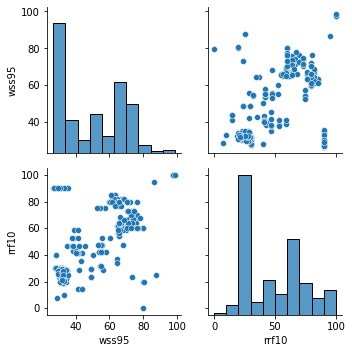

In [36]:
g = sns.PairGrid(df_state_metrics[df_state_metrics["stage"] == MAPPING_STAGES["noisy_inclusion"]][['wss95', 'rrf10']])
g.map_offdiag(sns.scatterplot)
g.map_diag(sns.histplot)

#### Expert-inclusions

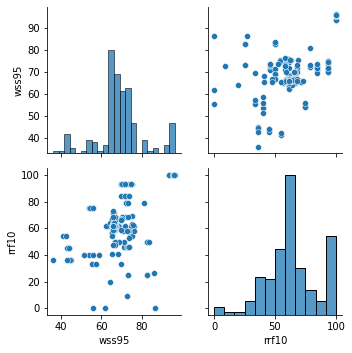

In [37]:
g = sns.PairGrid(df_state_metrics[df_state_metrics["stage"] == MAPPING_STAGES["expert_inclusion"]][['wss95', 'rrf10']])
g.map_offdiag(sns.scatterplot)
g.map_diag(sns.histplot)

#### Fulltext-inclusions

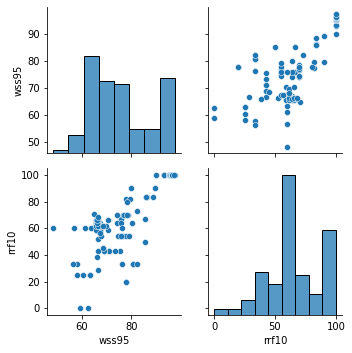

In [38]:
g = sns.PairGrid(df_state_metrics[df_state_metrics["stage"] == MAPPING_STAGES["fulltext_inclusion"]][['wss95', 'rrf10']])
g.map_offdiag(sns.scatterplot)
g.map_diag(sns.histplot)

### Raw results descriptives and metrics correlations

#### Merge the metrics and descriptives

In [39]:
df_combined_descriptives_metric = df_state_metrics.drop(['stage', 'title'], axis = 1).merge(df_data_descriptives_full, on = "dataset_name", how = "left")
print(len(df_combined_descriptives_metric))
df_combined_descriptives_metric.head()

638


,dataset_name,raw_stage_x,title_id_x,state_name,model,query_strategy,balance_strategy,feature_extraction,n_instances,wss95,...,n_missing_abstract,n_missing_abstract_%,n_missing_abstract_included,n_missing_abstract_included_%,title_length,abstract_length,n_keywords,screeningtime,kappa,recall_random95
0,data/Distal_radius_fractures_approach_expert_i...,expert_inclusion,1,output/simulation/Distal_radius_fractures_appr...,nb,max,double,tfidf,1,53.804348,...,13,6.67,0,0.0,113.979487,1277.405128,NaN,225,0.31,162.0
1,data/Distal_radius_fractures_approach_expert_i...,expert_inclusion,1,output/simulation/Distal_radius_fractures_appr...,nb,max,double,tfidf,1,64.130435,...,13,6.67,0,0.0,113.979487,1277.405128,NaN,225,0.31,162.0
2,data/Distal_radius_fractures_approach_expert_i...,expert_inclusion,1,output/simulation/Distal_radius_fractures_appr...,nb,max,double,tfidf,1,51.630435,...,13,6.67,0,0.0,113.979487,1277.405128,NaN,225,0.31,162.0
3,data/Distal_radius_fractures_approach_expert_i...,expert_inclusion,1,output/simulation/Distal_radius_fractures_appr...,nb,max,double,tfidf,1,61.956522,...,13,6.67,0,0.0,113.979487,1277.405128,NaN,225,0.31,162.0
4,data/Distal_radius_fractures_approach_expert_i...,expert_inclusion,1,output/simulation/Distal_radius_fractures_appr...,nb,max,double,tfidf,1,58.695652,...,13,6.67,0,0.0,113.979487,1277.405128,NaN,225,0.31,162.0


#### Correlations between descriptives and metrics per label level

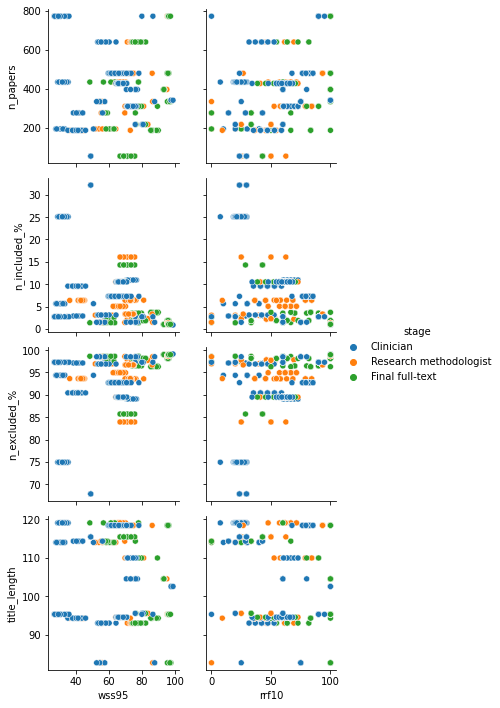

In [40]:
g = sns.PairGrid(
    df_combined_descriptives_metric, 
    x_vars = ['wss95', 'rrf10'], 
    y_vars =['n_papers',
            'n_included_%',
            'n_excluded_%',
            'title_length'],
    hue = "stage",
    hue_order = SCREENING_ORDER
)

g.map_offdiag(sns.scatterplot)
g.map_diag(sns.histplot)
g.add_legend()

#### Correlations between descriptives and metrics per dataset

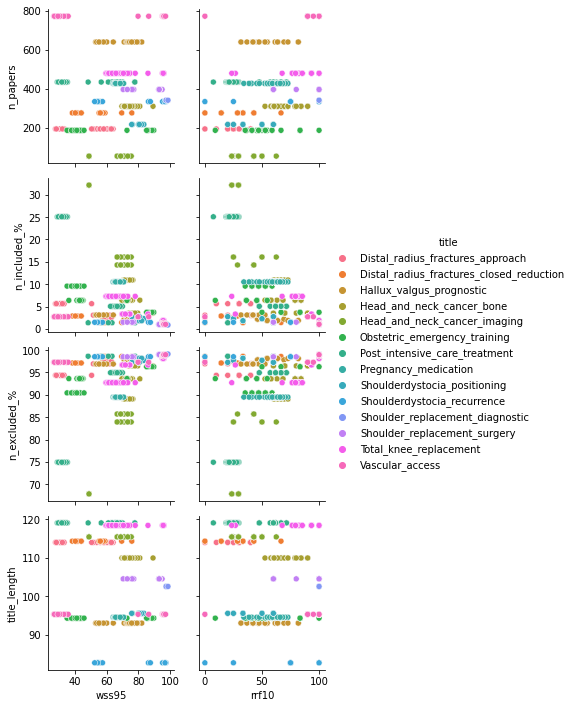

In [41]:
g = sns.PairGrid(
    df_combined_descriptives_metric, 
    x_vars = ['wss95', 'rrf10'], 
    y_vars =['n_papers',
            'n_included_%',
            'n_excluded_%',
            'title_length'],
    hue = "title"
)

g.map_offdiag(sns.scatterplot)
g.map_diag(sns.histplot)
g.add_legend()

### Aggregated data visualization

#### Noisy inclusions

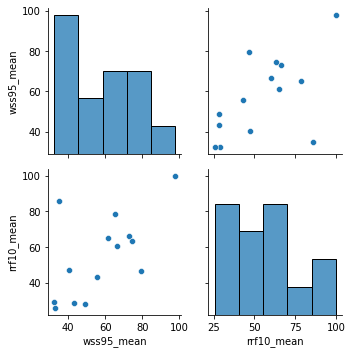

In [42]:
g = sns.PairGrid(metrics_per_dataset_noisy[['wss95_mean', 'rrf10_mean']])
g.map_offdiag(sns.scatterplot)
g.map_diag(sns.histplot)

#### Expert-inclusions

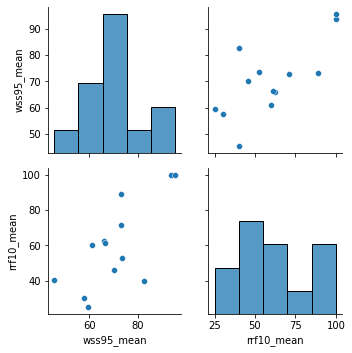

In [43]:
g = sns.PairGrid(metrics_per_dataset_expert[['wss95_mean', 'rrf10_mean']])
g.map_offdiag(sns.scatterplot)
g.map_diag(sns.histplot)

#### Fulltext-inclusions

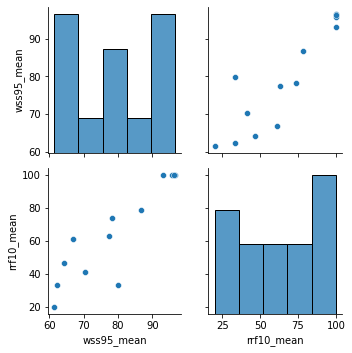

In [44]:
g = sns.PairGrid(metrics_per_dataset_fulltext[['wss95_mean', 'rrf10_mean']])
g.map_offdiag(sns.scatterplot)
g.map_diag(sns.histplot)

### Aggregated results per dataset per stage

#### Merge aggregated metrics with descriptives

In [45]:
df_combined_metrics_descriptives_agg = df_data_descriptives_with_meta.drop(['stage'], axis = 1).merge(metrics_per_dataset_per_stage_agg, on = "dataset_name", how = "left")
print(len(df_combined_metrics_descriptives_agg))
df_combined_metrics_descriptives_agg.head()

42


,dataset_name,title,raw_stage,title_id_x,n_papers,n_included,n_excluded,n_unlabeled,n_missing_title,n_missing_title_included,...,wss95_75%,wss95_max,rrf10_count,rrf10_mean,rrf10_std,rrf10_min,rrf10_25%,rrf10_50%,rrf10_75%,rrf10_max
0,data/Distal_radius_fractures_approach_expert_i...,Distal_radius_fractures_approach,expert_inclusion,1,195,6,189,0,0,0,...,61.14,64.13,6.0,30.00,16.73,0.0,25.0,40.00,40.00,40.00
1,data/Distal_radius_fractures_approach_fulltext...,Distal_radius_fractures_approach,fulltext_inclusion,1,195,5,190,0,0,0,...,63.04,63.04,5.0,20.00,11.18,0.0,25.0,25.00,25.00,25.00
2,data/Distal_radius_fractures_approach_noisy_in...,Distal_radius_fractures_approach,noisy_inclusion,1,195,11,184,0,0,0,...,32.61,50.54,11.0,29.09,8.31,10.0,30.0,30.00,30.00,40.00
3,data/Distal_radius_fractures_closed_reduction_...,Distal_radius_fractures_closed_reduction,expert_inclusion,2,277,4,273,0,0,0,...,60.24,69.55,4.0,25.00,16.67,0.0,25.0,33.33,33.33,33.33
4,data/Distal_radius_fractures_closed_reduction_...,Distal_radius_fractures_closed_reduction,fulltext_inclusion,2,277,4,273,0,0,0,...,63.25,75.94,4.0,33.33,27.22,0.0,25.0,33.33,41.67,66.67


#### Correlations between descriptives and aggregated metrics: Per label-level

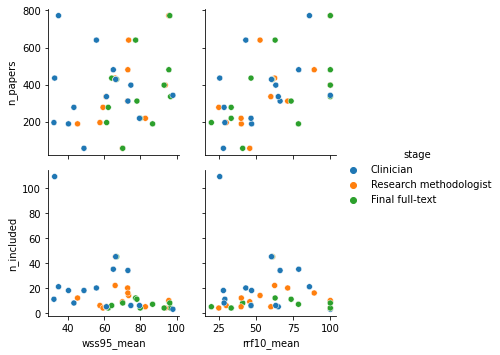

In [46]:
g = sns.PairGrid(
    df_combined_metrics_descriptives_agg, 
    x_vars = ['wss95_mean', 'rrf10_mean'], 
    y_vars =['n_papers',
            'n_included'],
    hue = "stage",
    hue_order = SCREENING_ORDER
)

g.map_offdiag(sns.scatterplot)
g.map_diag(sns.histplot)
g.add_legend()

In [47]:
list(df_combined_metrics_descriptives_agg)
list(df_combined_descriptives_metric)

['dataset_name',
 'raw_stage_x',
 'title_id_x',
 'state_name',
 'model',
 'query_strategy',
 'balance_strategy',
 'feature_extraction',
 'n_instances',
 'wss95',
 'wss100',
 'rrf5',
 'rrf10',
 'loss',
 'n_states',
 'dataset',
 'medical_specialty',
 'title',
 'type',
 'stage',
 'raw_stage_y',
 'title_id_y',
 'n_papers',
 'n_included',
 'n_included_%',
 'n_excluded',
 'n_excluded_%',
 'n_unlabeled',
 'n_unlabeled_%',
 'n_missing_title',
 'n_missing_title_%',
 'n_missing_title_included',
 'n_missing_title_included_%',
 'n_missing_abstract',
 'n_missing_abstract_%',
 'n_missing_abstract_included',
 'n_missing_abstract_included_%',
 'title_length',
 'abstract_length',
 'n_keywords',
 'screeningtime',
 'kappa',
 'recall_random95']

#### Correlations between descriptives and aggregated metrics: Per dataset

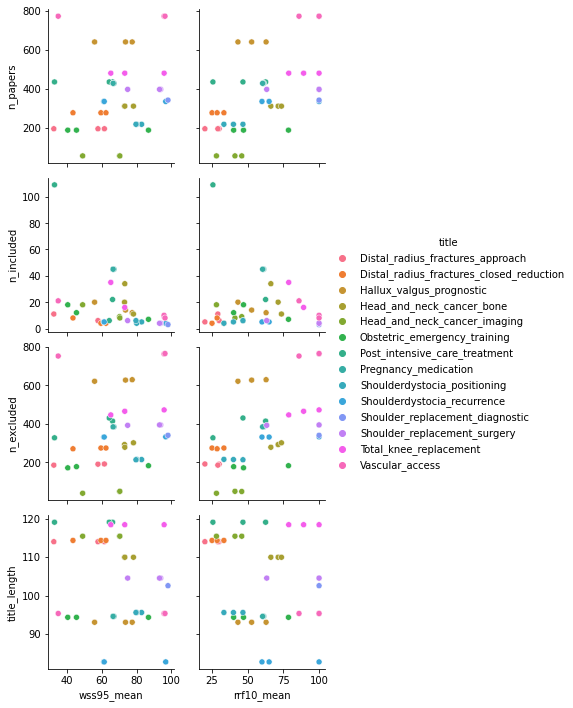

In [48]:
g = sns.PairGrid(
    df_combined_metrics_descriptives_agg, 
    x_vars = ['wss95_mean', 'rrf10_mean'], 
    y_vars =['n_papers',
            'n_included',
            'n_excluded',
            'title_length'],
    hue = "title"
)

g.map_offdiag(sns.scatterplot)
g.map_diag(sns.histplot)
g.add_legend()


### WSS95 plot full

In [49]:
df_state_metrics.sort_values('wss95')

fulltext_wss95_desc_order = grouped_wss_metrics[grouped_wss_metrics['stage'] == MAPPING_STAGES["fulltext_inclusion"]].sort_values('wss95', ascending = False)['title_id'].tolist()
fulltext_wss95_desc_order

## Number 9 is missing, because it has no full text inclusions:
fulltext_wss95_desc_order.insert(0,"9")

fulltext_wss95_desc_order

['9', '12', '14', '13', '10', '6', '11', '4', '3', '5', '8', '7', '2', '1']

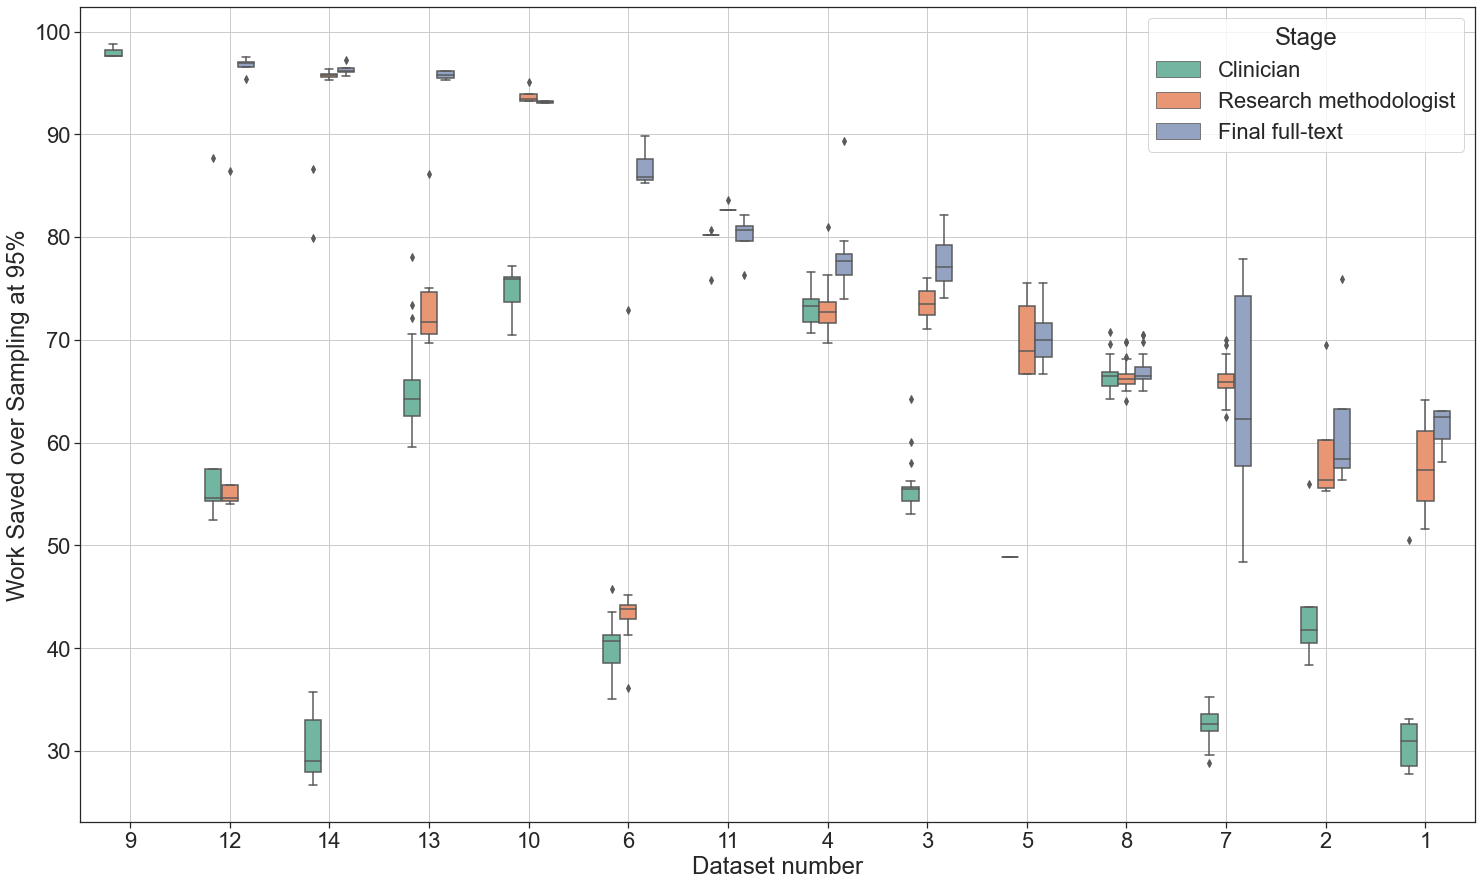

In [59]:
sns.set(rc={'figure.figsize':(25,15)}, font_scale = 2)
sns.set_style("ticks")
g_wss95 = sns.boxplot(x = "title_id", 
                      y = "wss95",
                      hue = "stage", 
                      data = df_state_metrics,
                      order = fulltext_wss95_desc_order,
                      hue_order = SCREENING_ORDER,
                     palette="Set2",
                     width=0.5)

g_wss95.grid(True)
g_wss95.set(xlabel ="Dataset number", ylabel = "Work Saved over Sampling at 95%")
g_wss95.legend(title="Stage")


#### Saving the image

In [51]:
g_wss95.figure.savefig("./output/figures/full_boxplot_wss95.png", bbox_inches='tight') 

#### Box plot for only a few datasets

In [52]:
# Only those titles which have box plots with many observations
selected_datasets = ["1",
    "3", 
    "4",
    "8",
    "7",
    "13"]


df_state_metrics_short = df_state_metrics.loc[df_state_metrics.title_id.isin(selected_datasets)]

fulltext_wss95_desc_order_short = [t for t in fulltext_wss95_desc_order if t in selected_datasets]
fulltext_wss95_desc_order_short


['13', '4', '3', '8', '7', '1']

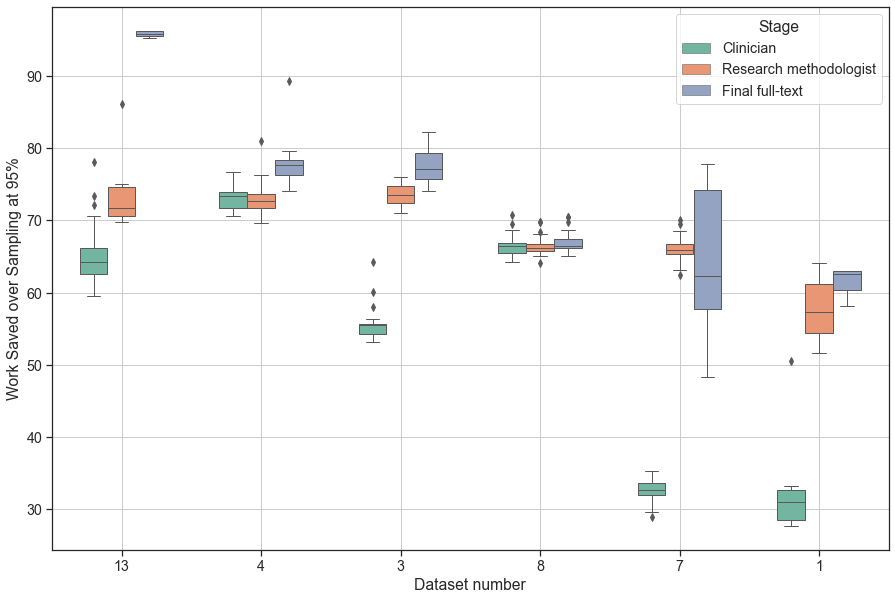

In [53]:
sns.set(rc={'figure.figsize':(15,10)}, font_scale = 1.3)
sns.set_style("ticks")

g_wss95 = sns.boxplot(x = "title_id", 
                      y = "wss95",
                      hue = "stage", 
                      data = df_state_metrics_short,
                      order = fulltext_wss95_desc_order_short, 
                      hue_order = SCREENING_ORDER,
                      palette="Set2",
                      dodge=True,
                      linewidth=1,
                     width=0.6)
g_wss95.grid(True)
g_wss95.set(xlabel ="Dataset number", ylabel = "Work Saved over Sampling at 95%")
g_wss95.legend(title="Stage")


#### Saving the image

In [54]:
g_wss95.figure.savefig("./output/figures/boxplot_wss95.png",bbox_inches='tight') 

### RRF10 plot full

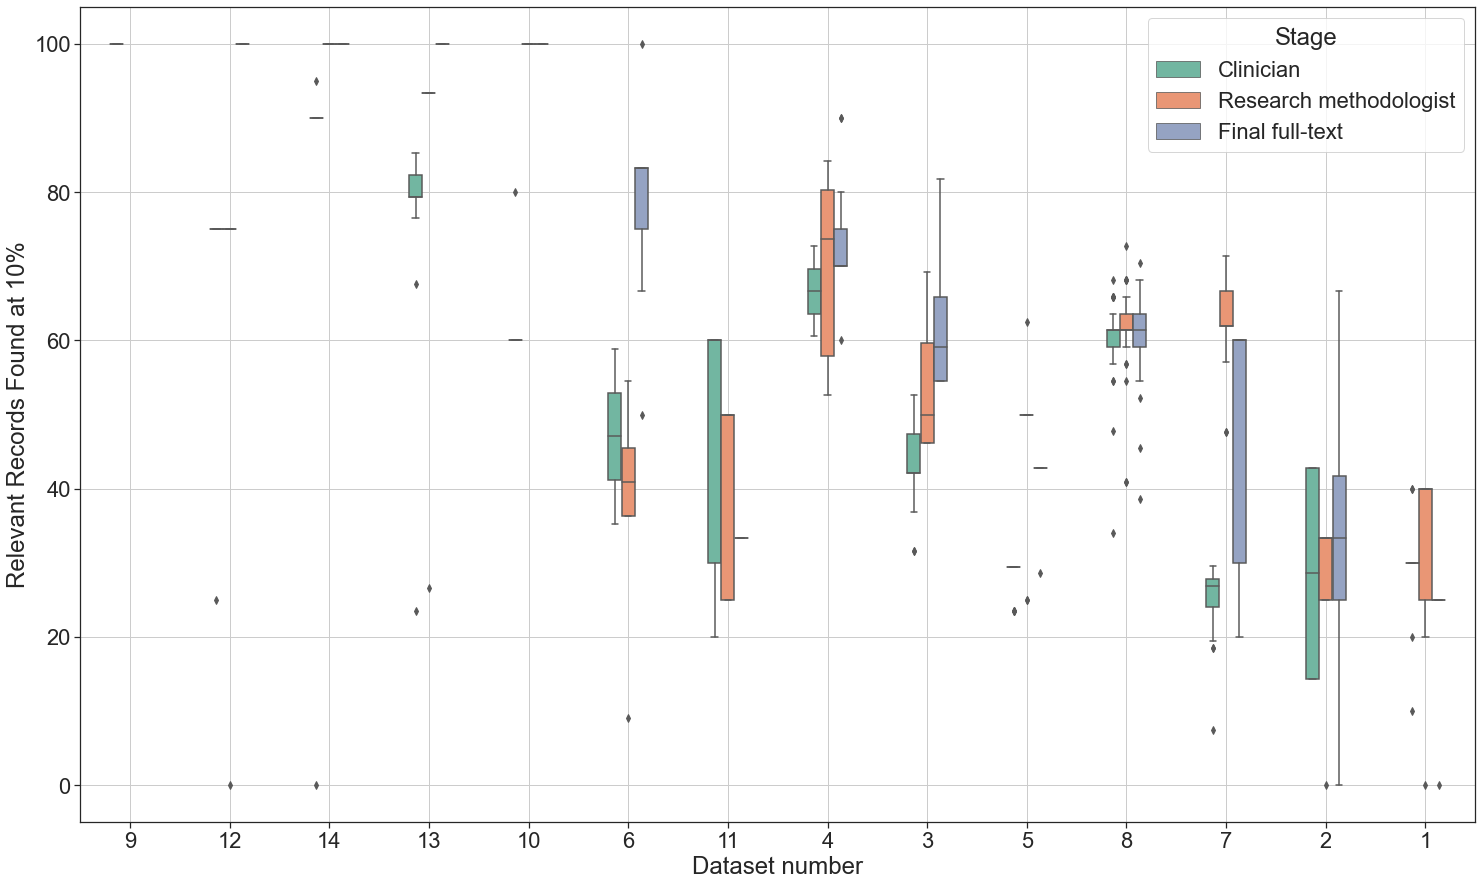

In [55]:
sns.set(rc={'figure.figsize':(25,15)}, font_scale = 2)
sns.set_style("ticks")
g_rrf10 = sns.boxplot(x = "title_id", 
                      y = "rrf10",
                      hue = "stage", 
                      data = df_state_metrics,
                      order = fulltext_wss95_desc_order,
                      hue_order = SCREENING_ORDER,
                     palette="Set2",
                     width=0.4)

g_rrf10.grid(True)
g_rrf10.set(xlabel ="Dataset number", ylabel = "Relevant Records Found at 10%")
g_rrf10.legend(title="Stage")

#### Saving the plot

In [56]:
g_rrf10.figure.savefig("./output/figures/full_boxplot_rrf10.png",bbox_inches='tight') 

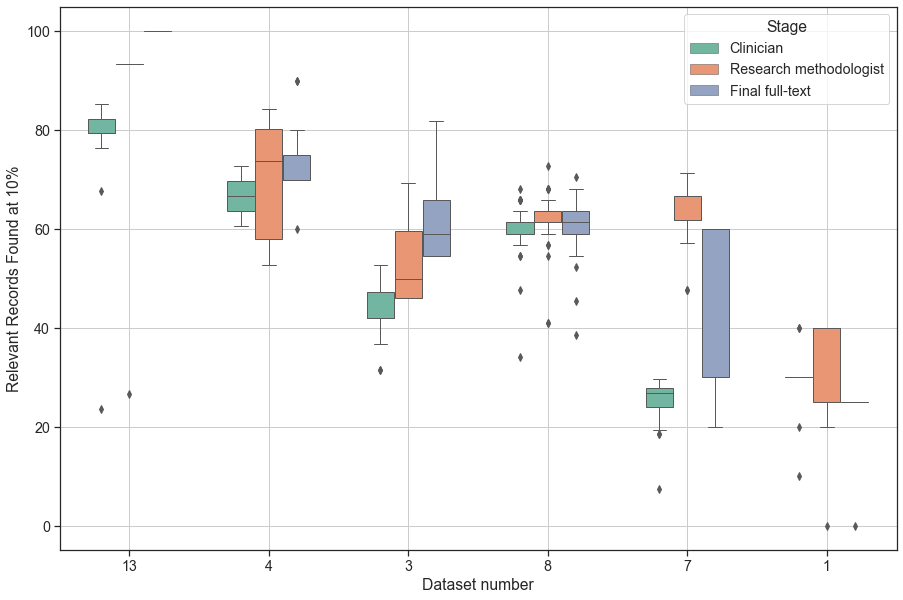

In [57]:
sns.set(rc={'figure.figsize':(15,10)}, font_scale = 1.3)
sns.set_style("ticks")
g_rrf10 = sns.boxplot(x = "title_id",
                      y = "rrf10",
                      hue = "stage", 
                      data = df_state_metrics_short,
                      order = fulltext_wss95_desc_order_short, 
                      hue_order = SCREENING_ORDER,
                      palette="Set2",
                      dodge=True,
                      linewidth=1,
                     width = 0.6)

g_rrf10.grid(True)
g_rrf10.set(xlabel ="Dataset number", ylabel = "Relevant Records Found at 10%")
g_rrf10.legend(title="Stage")

#### Saving the image

In [58]:
g_rrf10.figure.savefig("./output/figures/boxplot_rrf10.png",bbox_inches='tight') 